# Overview

We aim to solve the energy equation,
$$\rho C \left( \frac{\partial T}{\partial t} + \mathbf{u} \cdot \nabla T \right) = k \nabla^2 T$$
where $\rho$, $C$ and $k$ are fluid density, specific heat, and thermal conductivity, respectively.

$\mathbf{u} = - K\nabla p$.

# Steps
First, we need to solve $\mathbf{u}$. This is done by solving Darcy's law:
$$-\nabla \cdot (K \nabla p) = f$$
where $K$ is the permeability tensor, and $f$ is a source term.

## Solving Darcy's

Disregarding sources, $f$, Darcy's law is only one equation to be discretized, namely $\nabla \cdot (K\nabla p)$. This term can be discretized using two-point flux approximation.

When that is done, we may compute the Darcy flux, $\mathbf{u}$, to be used as parameter for the energy equation.

## Solving transport

The transport problem consists of two, possibly three terms.

The mass term, $\frac{\partial T}{\partial t}$, the advection term, $\mathbf{u} \cdot \nabla T$, and possibly the diffusive term, $k\nabla^2 T$. 

These terms are discretized using `MassMatrix`, `(Implicit)Upwind` and `(Implicit)Tpfa`, respectively.

The parathesized "implicit" simply multiplies the respective matrices and right-hand side with the time-step. Then, we can simply assemble and solve the assembled system at every time-step, without having to multiply with the time-step at the correct terms.

# Let's get coding!

First, we need some basic imports: `PorePy`, `numpy`, which handles vectors, and `scipy`, which handles (sparse) matrices.

In [161]:
import porepy as pp
import numpy as np
import scipy.sparse as sps

Next, we want to make a function that creates a simple grid for us.

In [162]:
def make_grid(nx=[5,5]):
    #g = pp.CartGrid([Nx, Nx], [2, 2])
    gb = pp.meshing.cart_grid([], nx)
    gb.compute_geometry()
    gb.assign_node_ordering()
    return gb

In [193]:
n = 20
gb = make_grid([n,n])
g = gb.grids_of_dimension(2)[0]
data = gb.node_props(g)

Add boundary conditions

In [194]:
tol=1e-4
bc_val = np.zeros(g.num_faces)

# Locate boundary faces
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

# Get coordinates of center of faces on boundary
b_face_centers = g.face_centers[:, b_faces]

# Find location of west and east face
b_inflow = b_face_centers[0,:] < tol
b_outflow = b_face_centers[0, :] > n - tol

# Label the faces
labels = np.array(['neu']*b_faces.size)

# Label west and east face as dirichlet
labels[np.logical_or(b_inflow, b_outflow)] = 'dir'

# Create bc object
bc = pp.BoundaryCondition(g, b_faces, labels)

bc_val[b_faces[b_inflow]] = 1

Add some data (mostly default)

In [195]:
keyword_flow = 'flow'

specified_parameters = {
    'bc': bc,
    'bc_values': bc_val,
}
_ = pp.initialize_default_data(g, data, keyword_flow, 
                               specified_parameters)

Discretize and solve the flow problem

In [196]:
flow_discretization = pp.Tpfa(keyword_flow)
flow_discretization.discretize(g, data)
A, b = flow_discretization.assemble_matrix_rhs(g, data)

pressure = sps.linalg.spsolve(A,b)
state = {keyword_flow: pressure}
_ = pp.set_state(data, state)

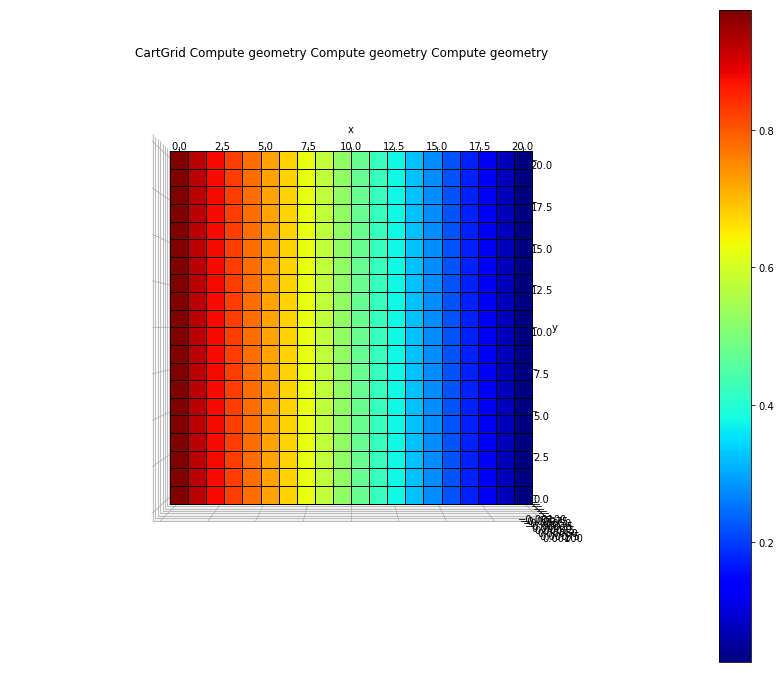

In [197]:
pp.plot_grid(g, pressure, figsize=(15, 12))

# Next, solve transport problem
Set up the problem. We only need to compute the Darcy flux, then initialize the other values by default

In [198]:
keyword_transport = "transport"
variable_transport = 'temperature'

# Darcy flux:
parameter_dictionary = data[pp.PARAMETERS][keyword_flow]
matrix_dictionary = data[pp.DISCRETIZATION_MATRICES][keyword_flow]
flx = (matrix_dictionary['flux'] * data[pp.STATE][keyword_flow]
       + matrix_dictionary['bound_flux'] * parameter_dictionary['bc_values']
      )

Add boundary conditions. Neumann everywhere.

In [199]:
labels = np.array(['neu']*b_faces.size)
bc = pp.BoundaryCondition(g, b_faces, labels)
bc_val = np.zeros(g.num_faces)

specified_parameters = {
    'bc': bc,
    'bc_values': bc_val,
    'darcy_flux': flx,
    'time_step': 0.3
}
_ = pp.initialize_default_data(g, data, keyword_transport, 
                           specified_parameters)

Add initial conditions. Some tracer in a corner

In [208]:
T_0 = np.zeros(g.num_cells)
T_0[int(n*n/2)+int(n/2)] = 10
state = {variable_transport: T_0}
_ = pp.set_state(data, state)

Discretize and solve the flow problem. Recall the equations:

$$\rho C \left( \frac{\partial T}{\partial t} + \mathbf{u} \cdot \nabla T \right) = k \nabla^2 T$$.
We may let $\rho = C = k = 1$ to get
$$\frac{\partial T}{\partial t} + \mathbf{u} \cdot \nabla T = \nabla^2 T$$

#### First, a slight adjustment to pp.Tpfa:
We need to multiply with the timestep to make it work with ImplicitMassMatrix.

In [209]:
class ImplicitTpfa(pp.Tpfa):
    """
    Multiply all contributions by the time step.
    """

    def assemble_matrix_rhs(self, g, data):
        """ Overwrite TPFA method to be consistent with the Biot dt convention.
        """
        a, b = super().assemble_matrix_rhs(g, data)
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]
        a = a * dt
        b = b * dt
        return a, b

In [210]:
# Import the implicit discretization
from porepy.utils.derived_discretizations import implicit_euler as IE_discretizations

mass_term = 'mass'
advection_term = 'advection'
diffusion_term = 'diffusion'

mass_discretization = IE_discretizations.ImplicitMassMatrix(keyword_transport, 
                                                            variable_transport)
advection_discretization = pp.Upwind(keyword_transport)
diffusion_discretization = ImplicitTpfa(keyword_transport)

In [211]:
data[pp.PRIMARY_VARIABLES] = {
    variable_transport: {"cells": 1}
}
data[pp.DISCRETIZATION] = {
    variable_transport: {
        mass_term: mass_discretization,
        advection_term: advection_discretization,
        diffusion_term: diffusion_discretization,
    }
}

Assemble the system

In [216]:
assembler = pp.Assembler(gb)
assembler.discretize(term_filter=[mass_term, advection_term])

In [217]:
time_steps = np.arange(10)
stored_temps = []
for _ in time_steps:
    A, b = assembler.assemble_matrix_rhs()
    x = sps.linalg.spsolve(A,b)
    pp.set_state(data, {variable_transport: x})
    stored_temps.append(x)

In [218]:
import matplotlib.pyplot as plt

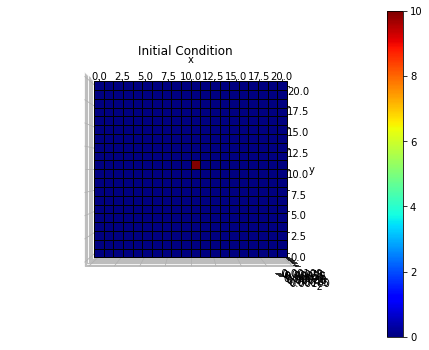

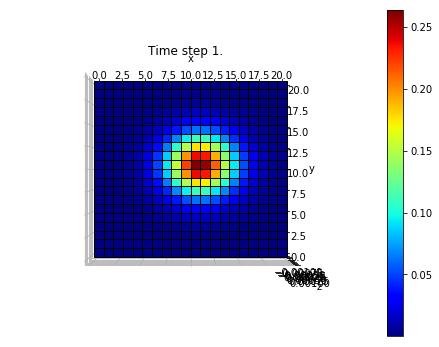

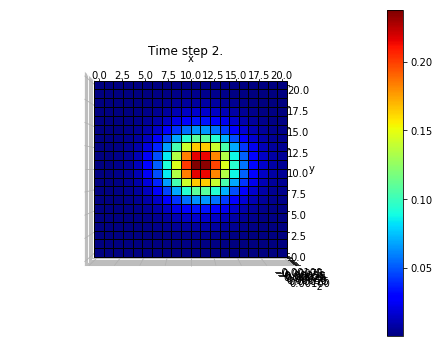

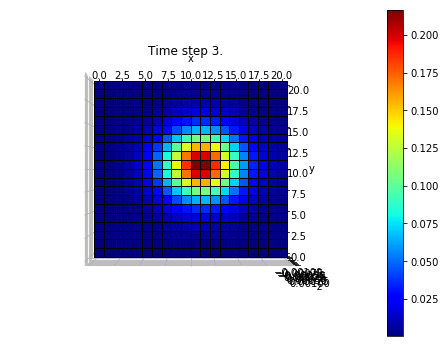

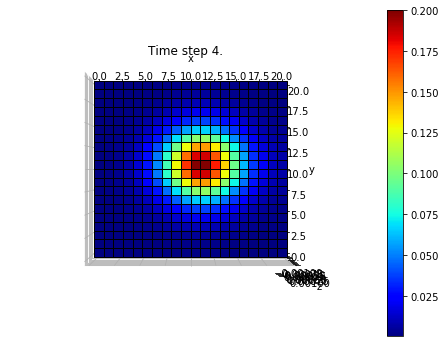

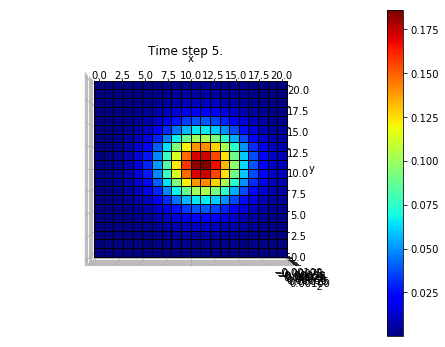

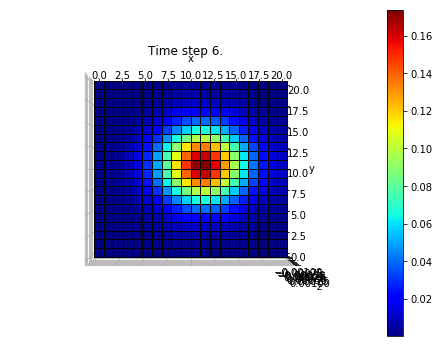

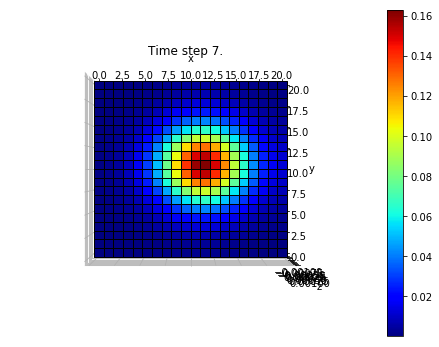

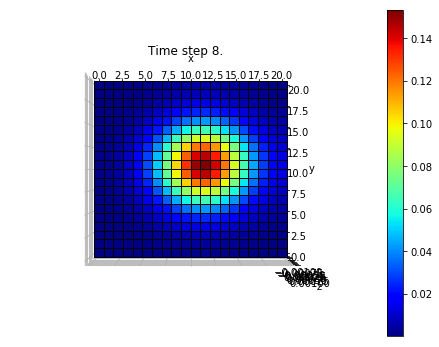

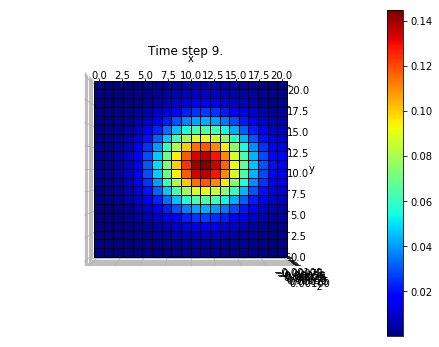

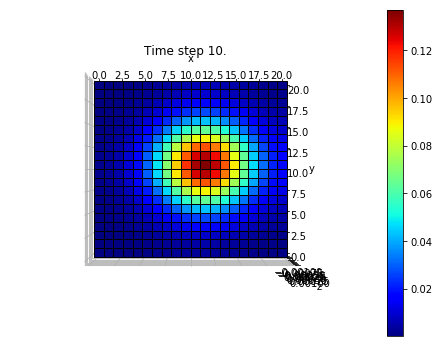

In [219]:
pp.plot_grid(g, T_0, figsize=(8,6), if_plot=False)
plt.title("Initial Condition")
for t in time_steps:
    pp.plot_grid(g, stored_temps[t], figsize=(8,6), if_plot=False)
    plt.title(f"Time step {t+1}.")
plt.show()